In [2]:
# importing libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Define file names and corresponding variable names
files = {
    "countryIndi": "Country_Indicators.csv",
    "country": "Country.csv",
    "economicIndi": "Economic_Indicators.csv",
    "enviroIndi": "Environmental_Indicators.csv",
    "qpsdIndi": "Public_Debt_Indicators_Agg.csv",
    "socialIndi": "Social_Indicators.csv",
    "statIndi": "Statistical_Indicators.csv",
    "yearIndi": "Year_Table.csv"
}

# Base path
base_path = '../WEEK 3/Indicators/'

# Read all files into a dictionary of DataFrames
data = {key: pd.read_csv(base_path + filename) for key, filename in files.items()}


In [4]:
data.keys()

dict_keys(['countryIndi', 'country', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi'])

In [5]:
data['country'].head(3)

,Country Name,Country Code,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Afghanistan,AFG,NaN,NaN,NaN
1,Albania,ALB,NaN,NaN,NaN
2,Algeria,DZA,NaN,NaN,NaN


In [6]:
# Fetch column shape from each DataFrame in the dictionary
for name, df in data.items():
    print(f"\nShape of '{name}': {df.shape[0]} rows, {df.shape[1]} columns")

data['country'].drop(columns=['Unnamed: 2', 'Unnamed: 3'], inplace=True)


Shape of 'countryIndi': 809 rows, 10 columns

Shape of 'country': 810 rows, 5 columns

Shape of 'economicIndi': 803 rows, 68 columns

Shape of 'enviroIndi': 803 rows, 11 columns

Shape of 'qpsdIndi': 318 rows, 67 columns

Shape of 'socialIndi': 803 rows, 75 columns

Shape of 'statIndi': 798 rows, 13 columns

Shape of 'yearIndi': 3 rows, 2 columns


In [7]:
import pandas as pd

# Step 1: Convert merge keys to the same type
for df_name in ['countryIndi', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi']:
    for col in ['Country Code', 'Time', 'Time Code']:
        if col in data[df_name].columns:
            data[df_name][col] = data[df_name][col].astype(str)

# Step 2: Start merging one by one
merged_df = data['countryIndi']

# Define list of other datasets to merge (excluding 'countryIndi' which is already used)
to_merge = ['economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi']

# Step 3: Merge all indicator datasets on 'Country Code' and 'Time'
for key in to_merge:
    merged_df = pd.merge(merged_df, data[key], on=['Country Code', 'Time'], how='outer', suffixes=('', f'_{key}'))

# Step 4: Merge the year table (to bring in Time Code if needed)
if 'Time Code' not in merged_df.columns:
    merged_df = pd.merge(merged_df, data['yearIndi'], on='Time', how='left')

# Optional: Merge country table to enrich with names if needed
#merged_df = pd.merge(merged_df, data['country'], on='Country Code', how='left', suffixes=('', '_country'))

# Step 5: Drop duplicate columns if any (like multiple 'Country Name' columns)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]


In [8]:
merged_df.head(5)

,Country Name,Country Code,Time,Time Code,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD],Adjusted net national income (current US$) [NY.ADJ.NNTY.CD],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG],Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD],Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD],...,Time Code_statIndi,Broad_Money_Perc,Broad_Money_Total,Broad_Money_Growth,Broad_Money_Reserves,Exchange_Rate,Total_Reserves_Perc,Total_Reserves_Gold,Total_Reserves_Months_Imports,Total_Reserves_Without_Gold
0,Afghanistan,AFG,2021.0,YR2021,-19.50573346,..,13621070039,-21.38008956,..,340.5232436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2022.0,YR2022,..,..,..,..,..,..,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,2023.0,YR2023,..,..,..,..,..,..,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,2021.0,YR2021,11.05709518,11130019640,14797555219,12.09128911,3958.514148,5262.913596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2022.0,YR2022,..,..,..,..,..,..,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
merged_df.shape

(2971, 234)

In [10]:
merged_df.isnull().sum()

Country Name                                                          2173
Country Code                                                             0
Time                                                                     0
Time Code                                                              798
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]    2173
                                                                      ... 
Exchange_Rate                                                         2173
Total_Reserves_Perc                                                   2173
Total_Reserves_Gold                                                   2173
Total_Reserves_Months_Imports                                         2173
Total_Reserves_Without_Gold                                           2173
Length: 234, dtype: int64

In [11]:
print("Number of rows with null Country Name:", merged_df['Country Name'].isna().sum())
null_countries = merged_df[merged_df['Country Name'].isna()]
null_countries

# lets drop such rows 
merged_df = merged_df[merged_df['Country Name'].notna()].reset_index(drop=True)
merged_df.shape

Number of rows with null Country Name: 2173


(798, 234)

In [12]:
merged_df.isnull().sum()

Country Name                                                            0
Country Code                                                            0
Time                                                                    0
Time Code                                                               0
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]      0
                                                                     ... 
Exchange_Rate                                                         798
Total_Reserves_Perc                                                   798
Total_Reserves_Gold                                                   798
Total_Reserves_Months_Imports                                         798
Total_Reserves_Without_Gold                                           798
Length: 234, dtype: int64

In [13]:
# Identify categorical columns to exclude
exclude_cols = ['Country Name', 'Country Code']  # Add more as needed

# Convert remaining columns to float safely
for col in merged_df.columns:
    if col not in exclude_cols:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

In [14]:
merged_df.isnull().sum()
merged_df['Time'] = pd.to_numeric(merged_df['Time'], errors='coerce').astype('Int64')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Columns: 234 entries, Country Name to Total_Reserves_Without_Gold
dtypes: Int64(1), float64(231), object(2)
memory usage: 1.4+ MB


In [14]:
#merged_df.columns.tolist()

Choose Columns Relevant to: 
"How have individual countries transitioned toward renewable energy and what are the patterns in emissions?"

Column Name : 	Why it is Relevant
- Country Name: Identify countries
- Time: 	For time series trends
- Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]:  Main variable for renewable energy transition
- Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e) [EN.GHG.CO2.MT.CE.AR5]: Total CO₂ emissions
- Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]: Yearly emissions % change
- Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]: Emissions per person
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]	: To check if economy size affects energy use/emissions

In [15]:
timeSeriesAnalysis_columns= [
 'Country Name',
 'Time',
 'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
 'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e) [EN.GHG.CO2.MT.CE.AR5]',
 'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
 'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]',
 'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]' 
]

df_timeAnalysis = merged_df[timeSeriesAnalysis_columns].copy()

# Rename for ease (optional)
df_timeAnalysis = df_timeAnalysis.rename(columns={
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]': 'GDP_growth(annual%)',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]': 'Yearly Emission%_change',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]' : 'Renewable_energy_consumption',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e) [EN.GHG.CO2.MT.CE.AR5]': 'CO2_total_emissions',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]': 'CO2_per_capita'

})

In [16]:
df_timeAnalysis.head(5)

,Country Name,Time,Renewable_energy_consumption,CO2_total_emissions,Yearly Emission%_change,CO2_per_capita,GDP_growth(annual%)
0,Afghanistan,2021,20.0,7.9308,171.398262,0.198268,-20.738839
1,Afghanistan,2022,20.0,8.2599,182.660324,0.203552,-6.240172
2,Afghanistan,2023,NaN,8.7073,197.970707,0.210043,2.710887
3,Albania,2021,41.9,5.0393,-24.164033,1.792283,8.969553
4,Albania,2022,NaN,4.6090,-30.639579,1.659293,4.826688


In [17]:
df_timeAnalysis.shape

(798, 7)

In [18]:
df_timeAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country Name                  798 non-null    object 
 1   Time                          798 non-null    Int64  
 2   Renewable_energy_consumption  283 non-null    float64
 3   CO2_total_emissions           753 non-null    float64
 4   Yearly Emission%_change       690 non-null    float64
 5   CO2_per_capita                753 non-null    float64
 6   GDP_growth(annual%)           754 non-null    float64
dtypes: Int64(1), float64(5), object(1)
memory usage: 44.5+ KB


In [19]:
df_timeAnalysis.describe()

,Time,Renewable_energy_consumption,CO2_total_emissions,Yearly Emission%_change,CO2_per_capita,GDP_growth(annual%)
count,798.0,283.000000,753.000000,690.000000,753.000000,754.000000
mean,2022.0,29.203180,1399.598449,697.586446,4.498405,4.475017
std,0.817009,28.206161,4695.915098,4373.338783,7.047401,5.953974
min,2021.0,0.000000,0.000000,-82.661980,0.000000,-28.758584
25%,2021.0,5.700000,3.808800,-1.336920,0.720071,2.380022
50%,2022.0,19.500000,24.163800,131.613598,2.602447,4.114274
75%,2023.0,48.700000,274.342400,278.724420,5.638792,6.200000
max,2023.0,96.300000,39023.937040,52827.272730,81.209455,75.061377


In [20]:
df_timeAnalysis.isnull().sum()

Country Name                      0
Time                              0
Renewable_energy_consumption    515
CO2_total_emissions              45
Yearly Emission%_change         108
CO2_per_capita                   45
GDP_growth(annual%)              44
dtype: int64

Option || When to Use || How
- Linear Interpolation (per country) || When renewable energy generally follows a smooth yearly trend (most countries) || Fill missing values by interpolating between previous and next known year
- Forward Fill (ffill) || If data is missing at the beginning || Fill missing with last known value
- Groupwise Mean (per country) || If country has constant renewables (flat trend) || Fill missing values with country's average renewable share

In [21]:
# filling missing values with and interploation method and forward fill method
# Step 1: Sort first
df_timeAnalysis = df_timeAnalysis.sort_values(['Country Name', 'Time'])

# Step 2: Interpolate Renewable Energy within each country
df_timeAnalysis['Renewable_energy_consumption'] = (
    df_timeAnalysis.groupby('Country Name')['Renewable_energy_consumption']
    .transform(lambda group: group.interpolate(method='linear'))
)

# Step 3: Forward fill and backward fill if still missing
df_timeAnalysis['Renewable_energy_consumption'] = (
    df_timeAnalysis.groupby('Country Name')['Renewable_energy_consumption']
    .transform(lambda group: group.ffill().bfill())
)
# Check again
df_timeAnalysis['Renewable_energy_consumption'].isnull().sum()

162

In [22]:
# Find countries where Renewable Energy Consumption is still missing
missing_renewable = (
    df_timeAnalysis[df_timeAnalysis['Renewable_energy_consumption'].isnull()]
    ['Country Name']
    .unique()
)

print("Countries with missing Renewable Energy Consumption:")
for country in missing_renewable:
    print(country)


Countries with missing Renewable Energy Consumption:
Africa Eastern and Southern
Africa Western and Central
Arab World
Caribbean small states
Central Europe and the Baltics
Channel Islands
Early-demographic dividend
East Asia & Pacific
East Asia & Pacific (IDA & IBRD countries)
East Asia & Pacific (excluding high income)
Euro area
Europe & Central Asia
Europe & Central Asia (IDA & IBRD countries)
Europe & Central Asia (excluding high income)
European Union
Fragile and conflict affected situations
Heavily indebted poor countries (HIPC)
High income
IBRD only
IDA & IBRD total
IDA blend
IDA only
IDA total
Kosovo
Late-demographic dividend
Latin America & Caribbean
Latin America & Caribbean (excluding high income)
Latin America & the Caribbean (IDA & IBRD countries)
Least developed countries: UN classification
Low & middle income
Low income
Lower middle income
Middle East & North Africa
Middle East & North Africa (IDA & IBRD countries)
Middle East & North Africa (excluding high income)
Middl

Above countries data is missing and we can drop those countries as :
- If a country has no data at all for Renewable Energy, interpolation cannot fix — it will still stay empty (which is correct).
- You can either drop such countries or mention it in your report ("Data unavailable for X countries").

In [23]:
#df_timeAnalysis['Time'] = pd.to_numeric(df_timeAnalysis['Time'], errors='coerce').astype('Int64')
# lets drop thos ecountries which have missing values in Renewable energy column

#  Drop those countries from the full dataset
df_timeAnalysis = df_timeAnalysis[~df_timeAnalysis['Country Name'].isin(missing_renewable)].copy()

# Reset index if needed
df_timeAnalysis.reset_index(drop=True, inplace=True)

# Check new shape
print(f"New dataset shape: {df_timeAnalysis.shape}")


New dataset shape: (636, 7)


In [24]:
df_timeAnalysis.head(5)

,Country Name,Time,Renewable_energy_consumption,CO2_total_emissions,Yearly Emission%_change,CO2_per_capita,GDP_growth(annual%)
0,Afghanistan,2021,20.0,7.9308,171.398262,0.198268,-20.738839
1,Afghanistan,2022,20.0,8.2599,182.660324,0.203552,-6.240172
2,Afghanistan,2023,20.0,8.7073,197.970707,0.210043,2.710887
3,Albania,2021,41.9,5.0393,-24.164033,1.792283,8.969553
4,Albania,2022,41.9,4.6090,-30.639579,1.659293,4.826688


Statistically prove relationships between these columns using:
- Using Correlation Matrix 
- Trend Visualization
- Regression Analysis

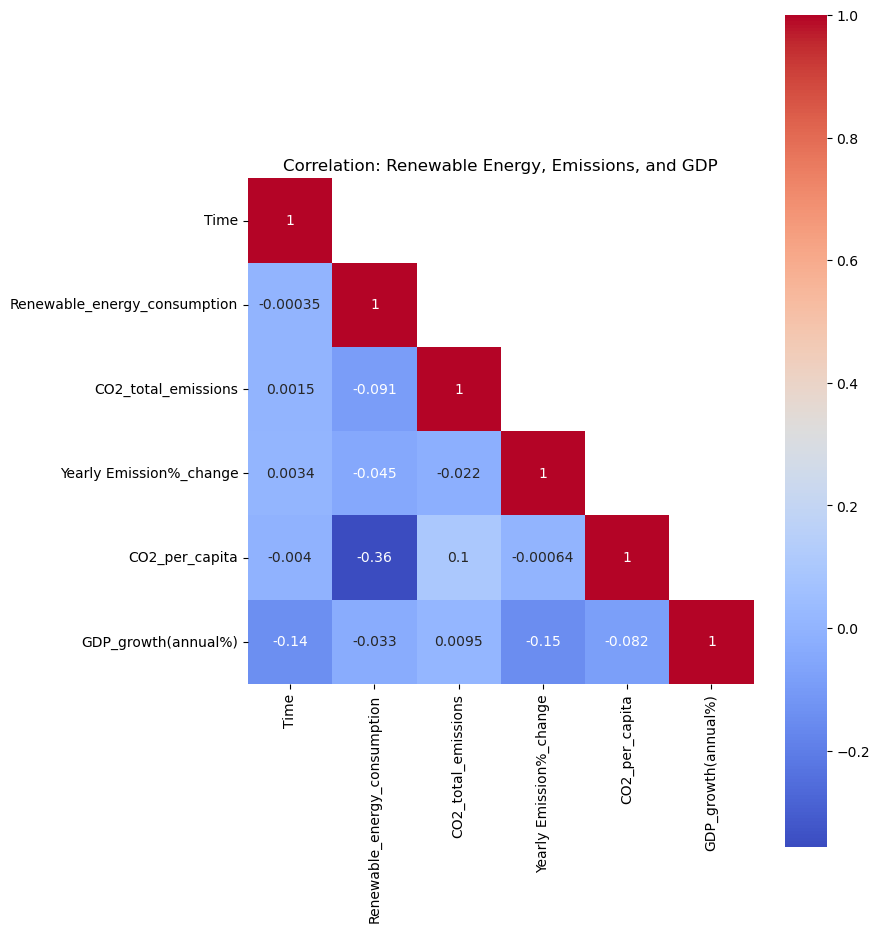

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Consider only numerical columns
numerical_cols = df_timeAnalysis.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute correlation matrix
corr_matrix = df_timeAnalysis[numerical_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=1)

# Plot the heatmap with mask
plt.figure(figsize=(9,10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation: Renewable Energy, Emissions, and GDP")
plt.tight_layout()
plt.show()


Strong negative correlation between Renewable Energy Consumption and CO₂ Emissions would prove that renewable adoption reduces emissions!

Interpretation of Correlation Heatmap:
1) Renewable_energy_consumption vs CO₂_per_capita:
- Correlation = -0.32 → Moderate negative correlation 
- Meaning: as renewable energy consumption increases, CO₂ emissions per person decrease — this supports your hypothesis about energy transition improving emissions.
2) Renewable_energy_consumption vs CO₂_total_emissions:
- Correlation = -0.078 → Weak negative correlation, but still slightly inverse 
- Interpretation: Slight evidence that as renewable share increases, total CO₂ emissions drop — though the effect is smaller globally (some big countries may dominate total emissions).
3) Renewable_energy_consumption vs Yearly Emission%_change:
- Correlation = -0.065 → Again weak negative, but logical: countries increasing renewables may slow down emission growth.
4) GDP_growth(annual%):
- GDP has small negative or very low correlations here, meaning economic growth and energy/emissions are somewhat independent in this sample.That's actually realistic because countries can grow GDP while shifting energy mix!



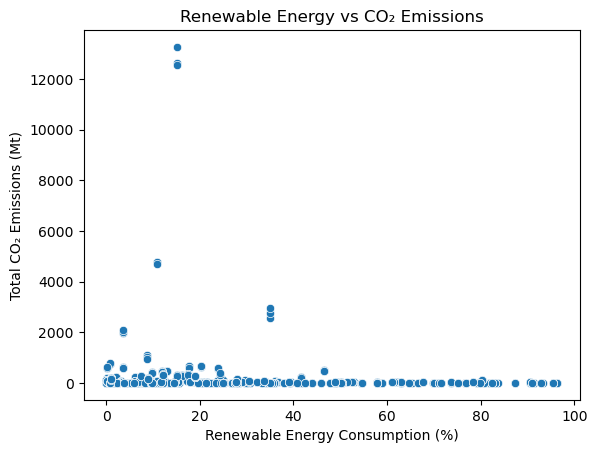

In [26]:
# Scatter renewable energy vs emissions
sns.scatterplot(
    data=df_timeAnalysis,
    x='Renewable_energy_consumption',
    y='CO2_total_emissions',
)
plt.title("Renewable Energy vs CO₂ Emissions")
plt.xlabel("Renewable Energy Consumption (%)")
plt.ylabel("Total CO₂ Emissions (Mt)")
plt.show()


In [27]:
import numpy as np
import statsmodels.api as sm

# 1. Drop missing values
df_timeAnalysis_clean = df_timeAnalysis[['Renewable_energy_consumption', 'CO2_total_emissions']].dropna()

# 2. Apply log transformation to emissions (important: add 1 to avoid log(0) if any)
df_timeAnalysis_clean['Log_CO2_emissions'] = np.log1p(df_timeAnalysis_clean['CO2_total_emissions'])

# 3. Regression: Log CO2 vs Renewable Energy
X = df_timeAnalysis_clean['Renewable_energy_consumption']
y = df_timeAnalysis_clean['Log_CO2_emissions']

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()

# 4. Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Log_CO2_emissions   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     25.99
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           4.60e-07
Time:                        17:09:09   Log-Likelihood:                -1278.2
No. Observations:                 609   AIC:                             2560.
Df Residuals:                     607   BIC:                             2569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

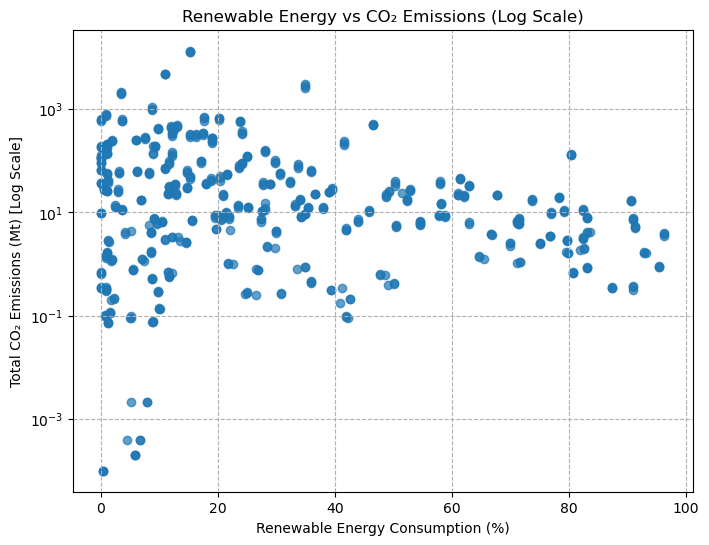

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))

# Scatter plot
plt.scatter(
    df_timeAnalysis['Renewable_energy_consumption'],
    df_timeAnalysis['CO2_total_emissions'],
    alpha=0.7
)

# Log scale on y-axis
plt.yscale('log')  # Key point!!

plt.xlabel('Renewable Energy Consumption (%)')
plt.ylabel('Total CO₂ Emissions (Mt) [Log Scale]')
plt.title('Renewable Energy vs CO₂ Emissions (Log Scale)')
plt.grid(True, which="both", ls="--")
plt.show()


You should observe a downward trend if higher renewable energy % → lower emissions.

After filling, always plot 2-3 countries' renewable energy curves to make sure interpolation looks natural (no weird spikes).

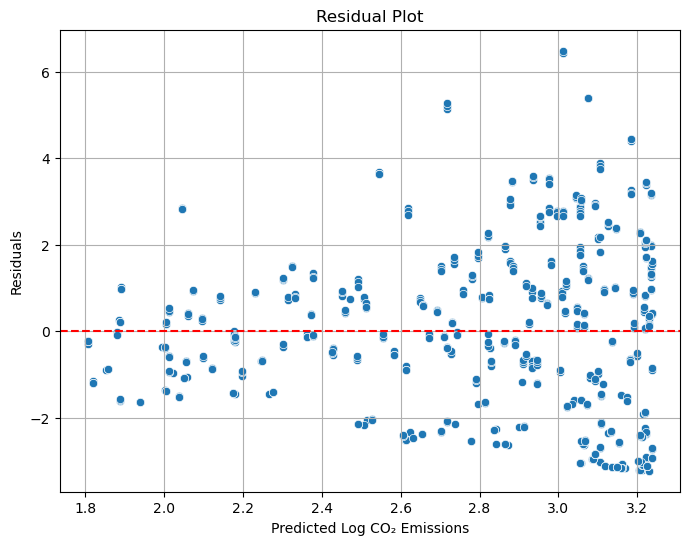

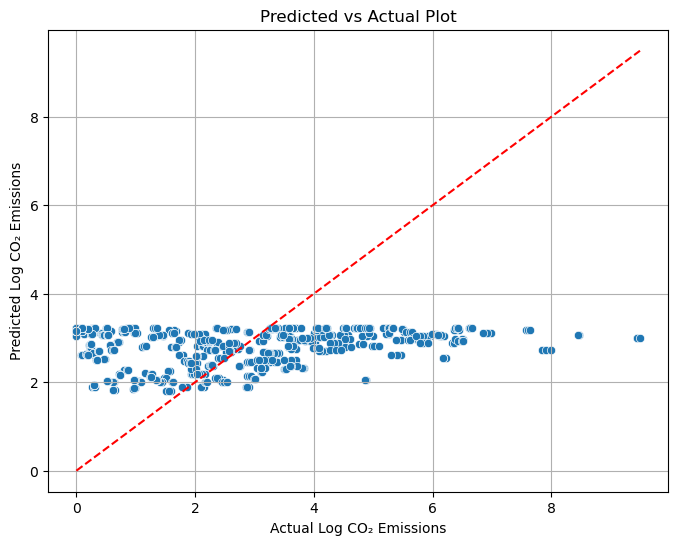

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predicted values
y_pred = model.predict(X)

# 2. Calculate residuals
residuals = y - y_pred

# --- 📈 Residual Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')  # reference line at zero
plt.xlabel('Predicted Log CO₂ Emissions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# --- 📊 Predicted vs Actual Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')  # 45 degree reference line
plt.xlabel('Actual Log CO₂ Emissions')
plt.ylabel('Predicted Log CO₂ Emissions')
plt.title('Predicted vs Actual Plot')
plt.grid(True)
plt.show()


In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. Prepare the dataset
# Create a working dataframe with all needed columns
df_multiple = df_timeAnalysis[['Renewable_energy_consumption', 'GDP_growth(annual%)', 'CO2_total_emissions',
                               'Yearly Emission%_change','CO2_per_capita']].dropna()

# 2. Log-transform CO2 emissions
df_multiple['Log_CO2_emissions'] = np.log1p(df_multiple['CO2_total_emissions'])

# 3. Define predictors and target
X_multi = df_multiple[['Renewable_energy_consumption', 'GDP_growth(annual%)','Yearly Emission%_change']]
y_multi = df_multiple['Log_CO2_emissions']

# 4. Add intercept
X_multi = sm.add_constant(X_multi)

# 5. Fit the multiple regression model
model_multi = sm.OLS(y_multi, X_multi).fit()

# 6. Show summary
print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:      Log_CO2_emissions   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     20.24
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.82e-12
Time:                        17:09:10   Log-Likelihood:                -1160.6
No. Observations:                 565   AIC:                             2329.
Df Residuals:                     561   BIC:                             2346.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

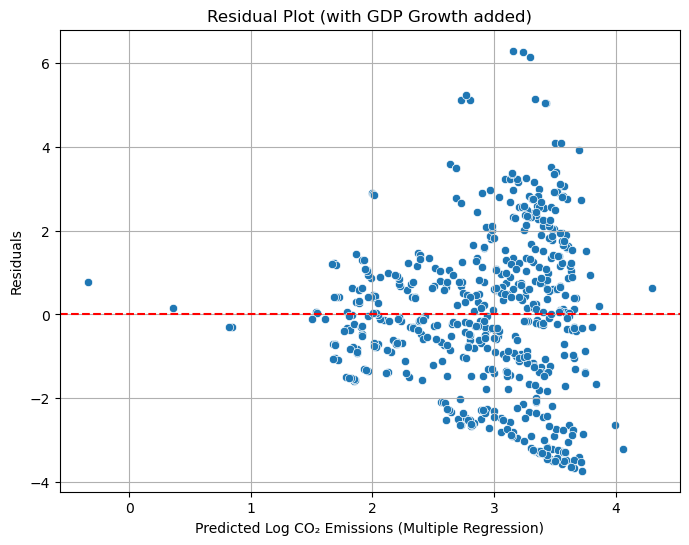

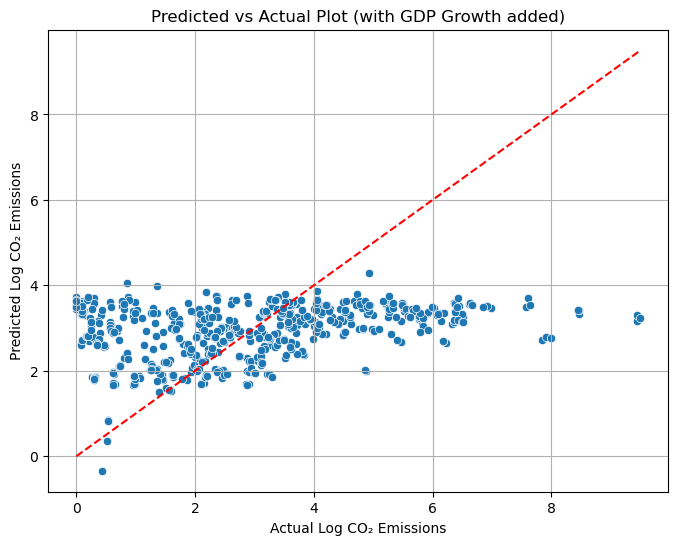

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get new predicted values
y_multi_pred = model_multi.predict(X_multi)

# 2. Calculate new residuals
residuals_multi = y_multi - y_multi_pred

# --- 📈 Updated Residual Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_multi_pred, y=residuals_multi)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Log CO₂ Emissions (Multiple Regression)')
plt.ylabel('Residuals')
plt.title('Residual Plot (with GDP Growth added)')
plt.grid(True)
plt.show()

# --- 📊 Updated Predicted vs Actual Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_multi, y=y_multi_pred)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], '--r')
plt.xlabel('Actual Log CO₂ Emissions')
plt.ylabel('Predicted Log CO₂ Emissions')
plt.title('Predicted vs Actual Plot (with GDP Growth added)')
plt.grid(True)
plt.show()


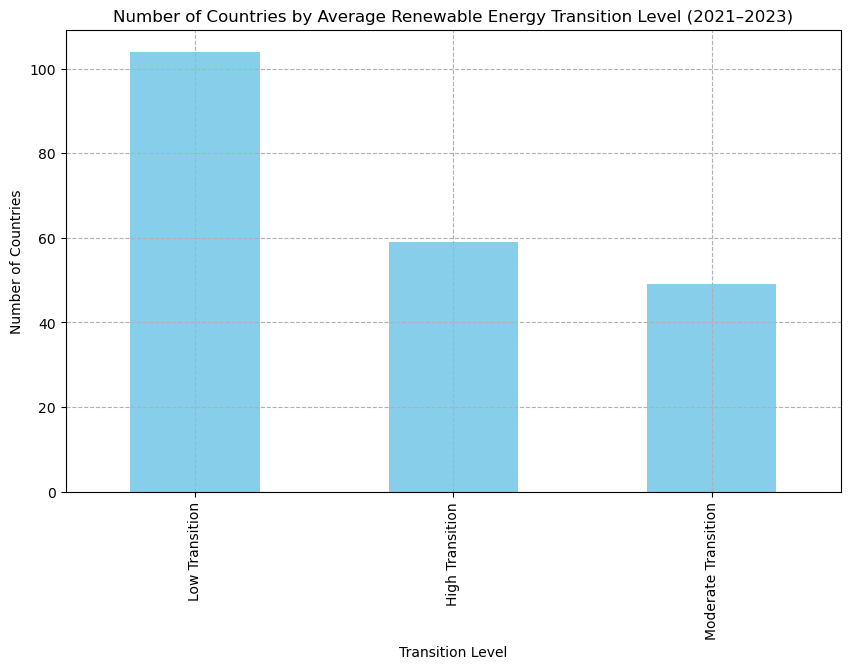

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Time' to datetime format
df_timeAnalysis['Time'] = pd.to_datetime(df_timeAnalysis['Time'], format='%Y')

# --- Filter relevant years 2021-2023 ---
df_transition = df_timeAnalysis[
    (df_timeAnalysis['Time'].dt.year >= 2021) & 
    (df_timeAnalysis['Time'].dt.year <= 2023)
]

# --- Calculate Average Renewable Energy Consumption per Country ---
avg_renewable = (
    df_transition
    .groupby('Country Name')['Renewable_energy_consumption']
    .mean()
    .reset_index()
    .rename(columns={'Renewable_energy_consumption': 'Avg_Renewable_Consumption_21_23'})
)

# --- Classify Countries Based on Renewable Adoption ---
def classify_transition(x):
    if x >= 40:
        return 'High Transition'
    elif 20 <= x < 40:
        return 'Moderate Transition'
    else:
        return 'Low Transition'

avg_renewable['Transition_Level'] = avg_renewable['Avg_Renewable_Consumption_21_23'].apply(classify_transition)

# --- Step 4: View Results ---
#print(avg_renewable.sort_values(by='Avg_Renewable_Consumption_21_23', ascending=False))

# --- Plot Transition Categories ---
plt.figure(figsize=(10,6))
avg_renewable['Transition_Level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Countries by Average Renewable Energy Transition Level (2021–2023)')
plt.xlabel('Transition Level')
plt.ylabel('Number of Countries')
plt.grid(True, linestyle='--')
plt.show()


In [33]:
# View High Transition countries
high_transition = avg_renewable[avg_renewable['Transition_Level'] == 'High Transition']
print(high_transition.head(3))

# View Moderate Transition countries
moderate_transition = avg_renewable[avg_renewable['Transition_Level'] == 'Moderate Transition']
print(moderate_transition.head(3))

# View Low Transition countries
low_transition = avg_renewable[avg_renewable['Transition_Level'] == 'Low Transition']
print(low_transition.head(3))


   Country Name  Avg_Renewable_Consumption_21_23 Transition_Level
1       Albania                             41.9  High Transition
5        Angola                             52.9  High Transition
20        Benin                             54.5  High Transition
   Country Name  Avg_Renewable_Consumption_21_23     Transition_Level
0   Afghanistan                             20.0  Moderate Transition
11      Austria                             36.0  Moderate Transition
15   Bangladesh                             25.0  Moderate Transition
     Country Name  Avg_Renewable_Consumption_21_23 Transition_Level
2         Algeria                              0.1   Low Transition
3  American Samoa                              0.4   Low Transition
4         Andorra                             18.6   Low Transition


In [34]:
df_timeAnalysis.columns

Index(['Country Name', 'Time', 'Renewable_energy_consumption',
       'CO2_total_emissions', 'Yearly Emission%_change', 'CO2_per_capita',
       'GDP_growth(annual%)'],
      dtype='object')

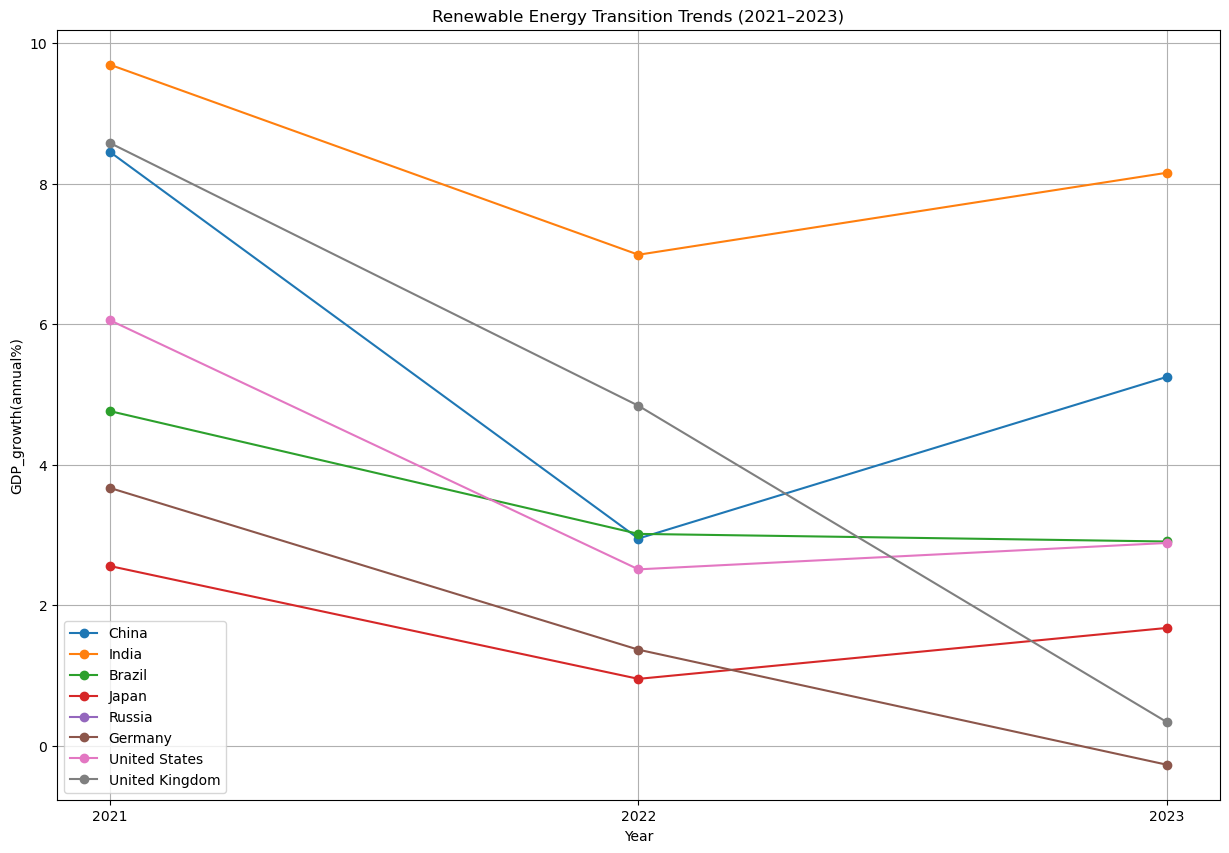

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Convert 'Time' if not done
df_timeAnalysis['Time'] = pd.to_datetime(df_timeAnalysis['Time'], format='%Y')

# 2. Filter for years 2021–2023
df_transition = df_timeAnalysis[
    (df_timeAnalysis['Time'].dt.year >= 2021) & 
    (df_timeAnalysis['Time'].dt.year <= 2023)
]

# 3. Choose some example countries (leaders, moderate, lagging)
example_countries = ['China', 'India', 'Brazil', 'Japan', 'Russia',
                     'Germany', 'United States', 'United Kingdom']



# 4. Plot
plt.figure(figsize=(15, 10))
#'Yearly Emission%_change', 'CO2_per_capita'
for country in example_countries:
    subset = df_transition[df_transition['Country Name'] == country]
    plt.plot(subset['Time'].dt.year, subset['GDP_growth(annual%)'], marker='o', label=country)



plt.title('Renewable Energy Transition Trends (2021–2023)')
plt.xlabel('Year')
plt.ylabel('GDP_growth(annual%)')
plt.xticks([2021, 2022, 2023])  # Force x-ticks to be only integer years
plt.legend()
plt.grid(True)
plt.show()


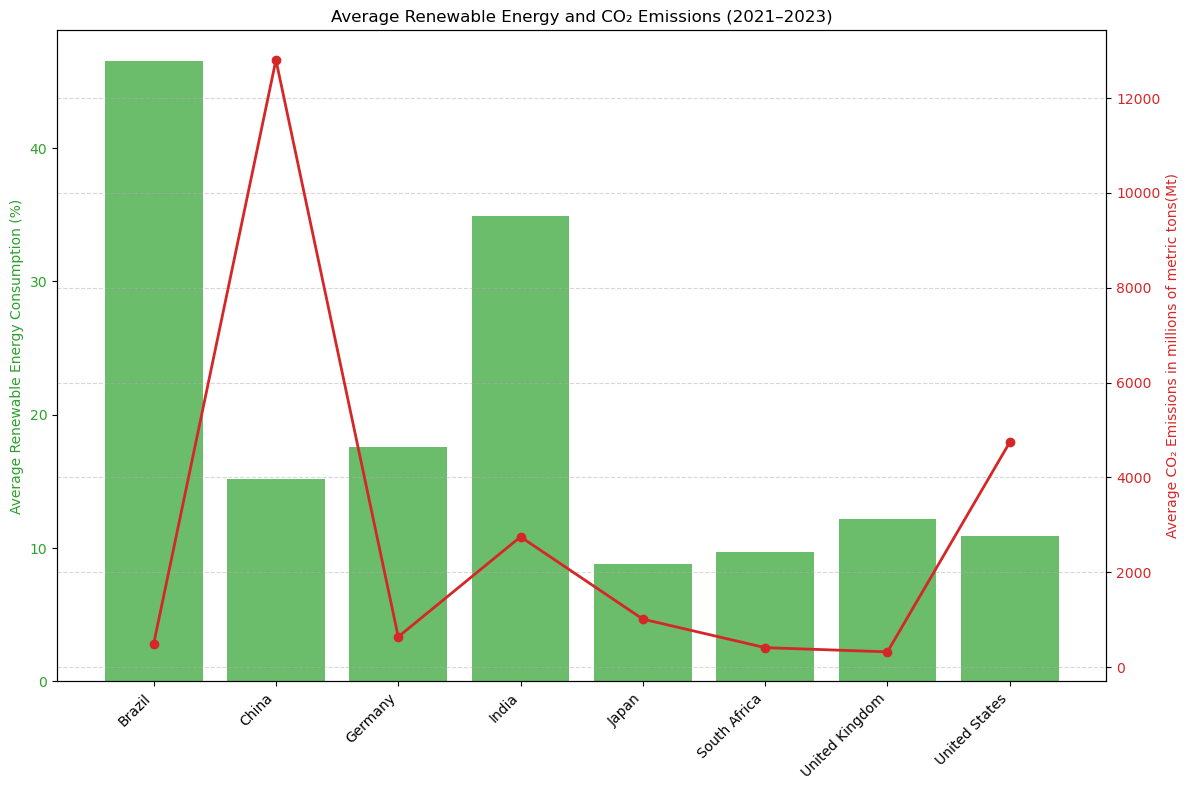

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Convert 'Time' if not done
df_timeAnalysis['Time'] = pd.to_datetime(df_timeAnalysis['Time'], format='%Y')

# 2. Filter for years 2021–2023
df_transition = df_timeAnalysis[
    (df_timeAnalysis['Time'].dt.year >= 2021) & 
    (df_timeAnalysis['Time'].dt.year <= 2023)
]

#'Yearly Emission%_change', 'CO2_per_capita'
# 3. Selected example countries
example_countries = ['China', 'India', 'Brazil', 'Japan', 'Russia',
                     'South Africa', 'Germany', 'United States', 'United Kingdom']

# 4. Calculate average Renewable and average CO2 for each selected country
avg_values = (
    df_transition[df_transition['Country Name'].isin(example_countries)]
    .groupby('Country Name')
    .agg({
        'Renewable_energy_consumption': 'mean',
        'CO2_total_emissions': 'mean'
    })
    .reset_index()
)



# 5. Plot both averages using twin axes
fig, ax1 = plt.subplots(figsize=(12,8))


# Bar plot for Renewable Energy (%)
color = 'tab:green'
ax1.bar(avg_values['Country Name'], avg_values['Renewable_energy_consumption'], color=color, alpha=0.7)
ax1.set_ylabel('Average Renewable Energy Consumption (%)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(avg_values['Country Name'], rotation=45, ha='right')

# Create a second y-axis for CO₂ emissions
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.plot(avg_values['Country Name'], avg_values['CO2_total_emissions'], color=color, marker='o', linewidth=2)
ax2.set_ylabel('Average CO₂ Emissions in millions of metric tons(Mt)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Average Renewable Energy and CO₂ Emissions (2021–2023)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



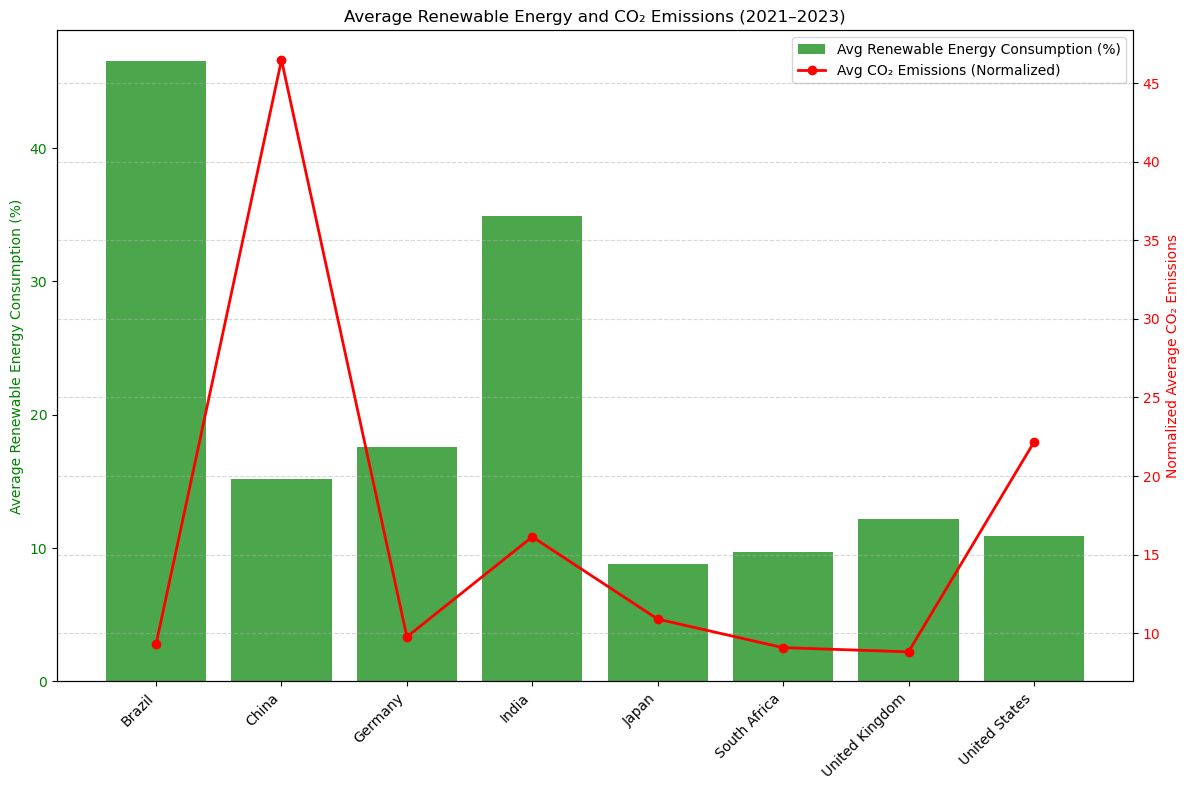

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Convert 'Time' if not done
df_timeAnalysis['Time'] = pd.to_datetime(df_timeAnalysis['Time'], format='%Y')

# 2. Filter for years 2021–2023
df_transition = df_timeAnalysis[
    (df_timeAnalysis['Time'].dt.year >= 2021) & 
    (df_timeAnalysis['Time'].dt.year <= 2023)
]

# 3. Selected example countries
example_countries = ['China', 'India', 'Brazil', 'Japan', 'Russia',
                     'South Africa', 'Germany', 'United States', 'United Kingdom']

# 4. Calculate average Renewable and average CO2 for each selected country
avg_values = (
    df_transition[df_transition['Country Name'].isin(example_countries)]
    .groupby('Country Name')
    .agg({
        'Renewable_energy_consumption': 'mean',
        'CO2_total_emissions': 'mean'
    })
    .reset_index()
)

# --- Normalize CO₂ emissions to match Renewable % scale ---
scaler = MinMaxScaler(feature_range=(avg_values['Renewable_energy_consumption'].min(), 
                                     avg_values['Renewable_energy_consumption'].max()))

avg_values['CO2_total_emissions_normalized'] = scaler.fit_transform(
    avg_values[['CO2_total_emissions']]
)

# 5. Plot both averages on a similar scale
fig, ax1 = plt.subplots(figsize=(12,8))

# Bar plot for Renewable Energy (%)
bars = ax1.bar(avg_values['Country Name'], avg_values['Renewable_energy_consumption'], 
               color='green', alpha=0.7, label='Avg Renewable Energy Consumption (%)')
ax1.set_ylabel('Average Renewable Energy Consumption (%)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticklabels(avg_values['Country Name'], rotation=45, ha='right')

# Create a second y-axis for CO₂ emissions (normalized)
ax2 = ax1.twinx()  
line, = ax2.plot(avg_values['Country Name'], avg_values['CO2_total_emissions_normalized'], 
                 color='red', marker='o', linewidth=2, label='Avg CO₂ Emissions (Normalized)')
ax2.set_ylabel('Normalized Average CO₂ Emissions', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and Grid
plt.title('Average Renewable Energy and CO₂ Emissions (2021–2023)')
plt.grid(True, linestyle='--', alpha=0.5)

# Combine legends
lines_labels = [bars, line]
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels, loc='upper right')

plt.tight_layout()
plt.show()


The green bars represent the average renewable energy consumption (% of total final energy consumption) for each country between 2021 and 2023.
The red line shows normalized average CO₂ emissions, rescaled to the same percentage range for comparative visualization.
Note: CO₂ emissions originally measured in million metric tons (Mt) have been normalized and are unitless in this chart.

This graph gives strong evidence to support your broader analysis about renewable energy transition and emissions patterns!

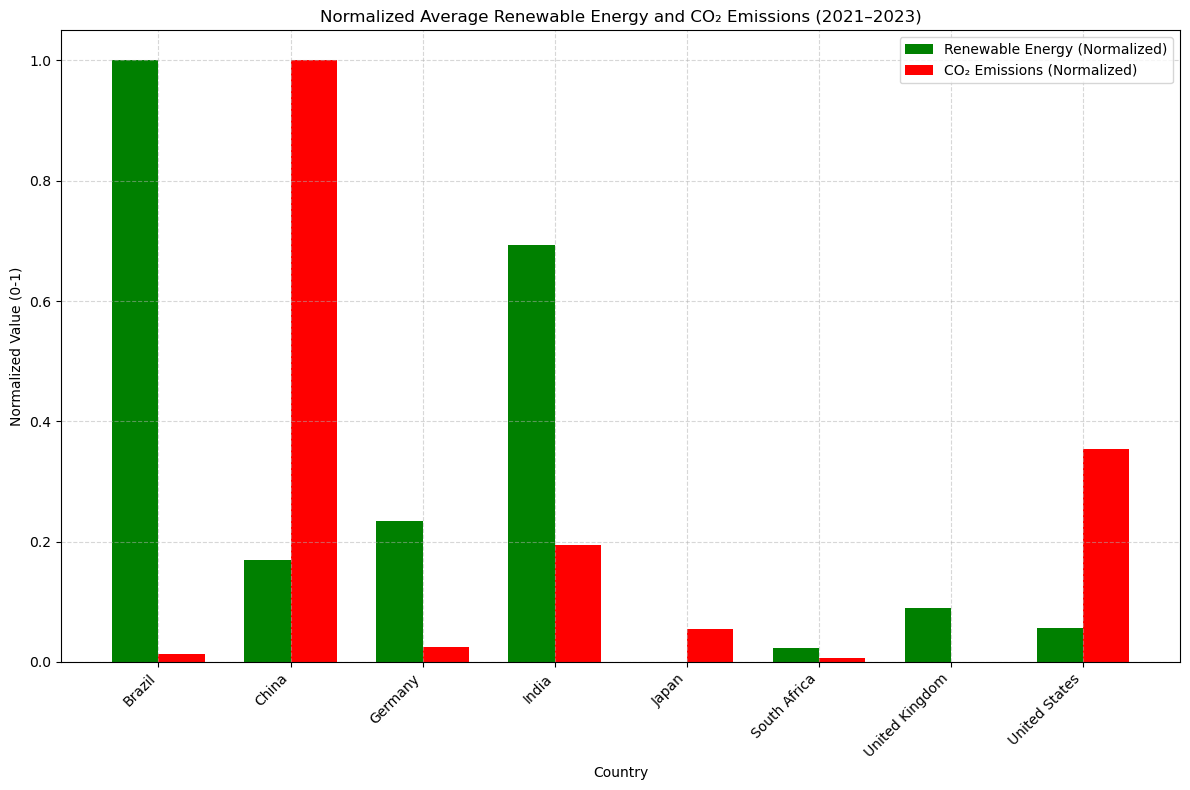

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Convert 'Time' if not done
df_timeAnalysis['Time'] = pd.to_datetime(df_timeAnalysis['Time'], format='%Y')

# 2. Filter for years 2021–2023
df_transition = df_timeAnalysis[
    (df_timeAnalysis['Time'].dt.year >= 2021) & 
    (df_timeAnalysis['Time'].dt.year <= 2023)
]

# 3. Selected example countries
example_countries = ['China', 'India', 'Brazil', 'Japan', 'Russia',
                     'South Africa', 'Germany', 'United States', 'United Kingdom']

# 4. Calculate average Renewable and average CO2 for each selected country
avg_values = (
    df_transition[df_transition['Country Name'].isin(example_countries)]
    .groupby('Country Name')
    .agg({
        'Renewable_energy_consumption': 'mean',
        'CO2_total_emissions': 'mean'
    })
    .reset_index()
)

# 5. Normalize both columns between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_values = avg_values.copy()
normalized_values[['Renewable_energy_consumption', 'CO2_total_emissions']] = scaler.fit_transform(
    avg_values[['Renewable_energy_consumption', 'CO2_total_emissions']]
)

# 6. Plot normalized Renewable and CO2 side-by-side
x = np.arange(len(normalized_values['Country Name']))  # X locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12,8))

bar1 = ax.bar(x - width/2, normalized_values['Renewable_energy_consumption'], width, label='Renewable Energy (Normalized)', color='green')
bar2 = ax.bar(x + width/2, normalized_values['CO2_total_emissions'], width, label='CO₂ Emissions (Normalized)', color='red')

ax.set_xlabel('Country')
ax.set_ylabel('Normalized Value (0-1)')
ax.set_title('Normalized Average Renewable Energy and CO₂ Emissions (2021–2023)')
ax.set_xticks(x)
ax.set_xticklabels(normalized_values['Country Name'], rotation=45, ha='right')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [39]:
# Top 3 countries with highest average Renewable Energy (2021–2023)
top3_renewable = avg_values.sort_values(by='Renewable_energy_consumption', ascending=False).head(3)

# Top 3 countries with lowest average CO₂ Emissions (2021–2023)
top3_low_emissions = avg_values.sort_values(by='CO2_total_emissions', ascending=True).head(3)

# Display both
print("🔹 Top 3 Countries by Highest Renewable Energy Consumption (2021–2023):")
print(top3_renewable[['Country Name', 'Renewable_energy_consumption']])

print("\n🔹 Top 3 Countries by Lowest CO₂ Emissions (2021–2023):")
print(top3_low_emissions[['Country Name', 'CO2_total_emissions']])


🔹 Top 3 Countries by Highest Renewable Energy Consumption (2021–2023):
  Country Name  Renewable_energy_consumption
0       Brazil                          46.5
3        India                          34.9
2      Germany                          17.6

🔹 Top 3 Countries by Lowest CO₂ Emissions (2021–2023):
     Country Name  CO2_total_emissions
6  United Kingdom           323.019767
5    South Africa           411.771200
0          Brazil           488.136667


Predict renewable energy consumption for next 2 years based on past data (2021–2023).

Trend Analysis (Model CO₂ Emission Drop Across Years)

CO2 Emission Trend Slope: -36.57 Mt per year


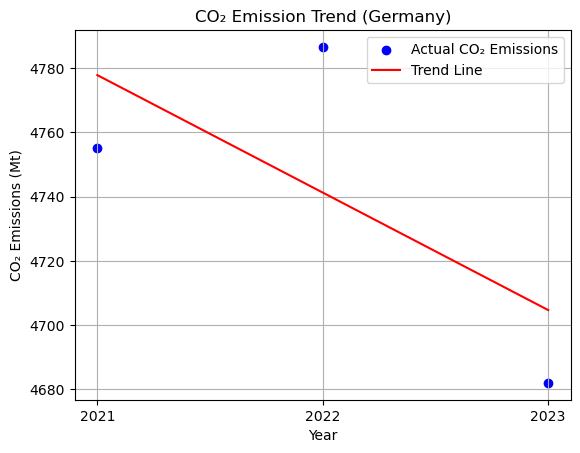

In [40]:
from sklearn.linear_model import LinearRegression
# Example: Germany CO₂ Emissions
subset = df_transition[df_transition['Country Name'] == 'United States']
X = subset['Time'].dt.year.values.reshape(-1,1)
y = subset['CO2_total_emissions'].values

# Linear Regression
model = LinearRegression()
model.fit(X, y)

print(f"CO2 Emission Trend Slope: {model.coef_[0]:.2f} Mt per year")

# Plot
plt.scatter(X, y, color='blue', label='Actual CO₂ Emissions')
plt.plot(X, model.predict(X), color='red', label='Trend Line')
plt.xlabel('Year')
plt.xticks([2021, 2022, 2023])
plt.ylabel('CO₂ Emissions (Mt)')
plt.title('CO₂ Emission Trend (Germany)')
plt.legend()
plt.grid(True)
plt.show()


Time Series Clustering (Group Similar Countries)

Showing top 20 countries in each cluster 


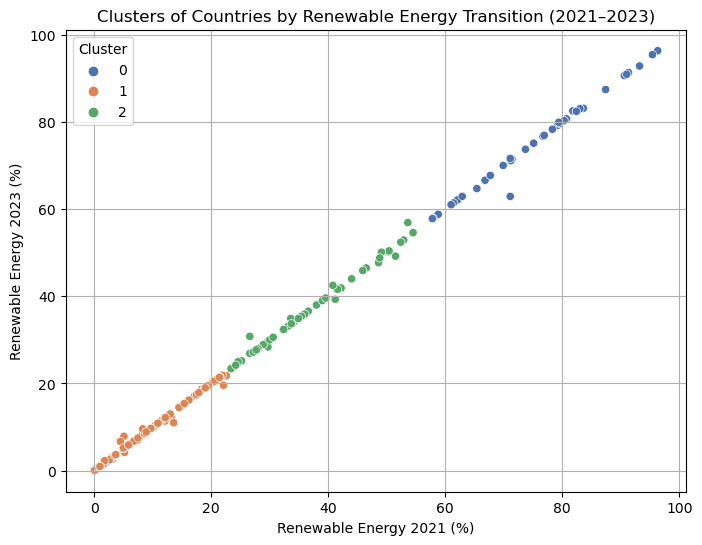


Cluster Mean Renewable Energy Values:
Time          2021       2023
Cluster                      
0        76.053659  75.851220
1         8.515789   8.497368
2        36.421053  36.517544

Top 50 Countries in Each Cluster (with Descriptive Labels):
           Moderate Adopters           Fast Adopters           Slow Adopters
0                     Bhutan             Afghanistan                 Albania
1               Burkina Faso                 Algeria                  Angola
2                    Burundi          American Samoa                 Austria
3                   Cameroon                 Andorra              Bangladesh
4   Central African Republic     Antigua and Barbuda                  Belize
5                       Chad               Argentina                   Benin
6           Congo, Dem. Rep.                 Armenia  Bosnia and Herzegovina
7                Congo, Rep.                   Aruba                Botswana
8              Cote d'Ivoire               Australia     

In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare dataset
pivot = df_transition.pivot_table(index='Country Name', columns=df_transition['Time'].dt.year, values='Renewable_energy_consumption')

# 2. Drop countries with missing values
pivot = pivot.dropna()

# 3. Scale data
scaler = StandardScaler()
scaled = scaler.fit_transform(pivot)

# 4. Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled)

# 5. Add cluster labels
pivot['Cluster'] = clusters

# 6. Optional scatter plot (still included)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pivot[2021], y=pivot[2023], hue=pivot['Cluster'], palette='deep')
plt.title('Clusters of Countries by Renewable Energy Transition (2021–2023)')
plt.xlabel('Renewable Energy 2021 (%)')
plt.ylabel('Renewable Energy 2023 (%)')
plt.grid(True)
plt.show()

# 7. Manually define cluster names (based on patterns)
# Here you can assign based on mean renewable energy values:
cluster_means = pivot.groupby('Cluster')[[2021, 2023]].mean()
print("\nCluster Mean Renewable Energy Values:")
print(cluster_means)

# Based on interpretation of the cluster_means:
# (You can adjust if you see differently after printing)
cluster_labels = {
    0: "Moderate Adopters",
    1: "Fast Adopters",
    2: "Slow Adopters"
}

# 8. Top 20 countries per cluster with proper labels
top_countries_by_cluster = {}

for cluster_num in sorted(pivot['Cluster'].unique()):
    label = cluster_labels[cluster_num]
    cluster_countries = pivot[pivot['Cluster'] == cluster_num].index.tolist()
    top_countries_by_cluster[label] = cluster_countries[:50]  # take top 20 only

# 9. Display as table
top_countries_table = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in top_countries_by_cluster.items()]))

print("\nTop 50 Countries in Each Cluster (with Descriptive Labels):")
print(top_countries_table)


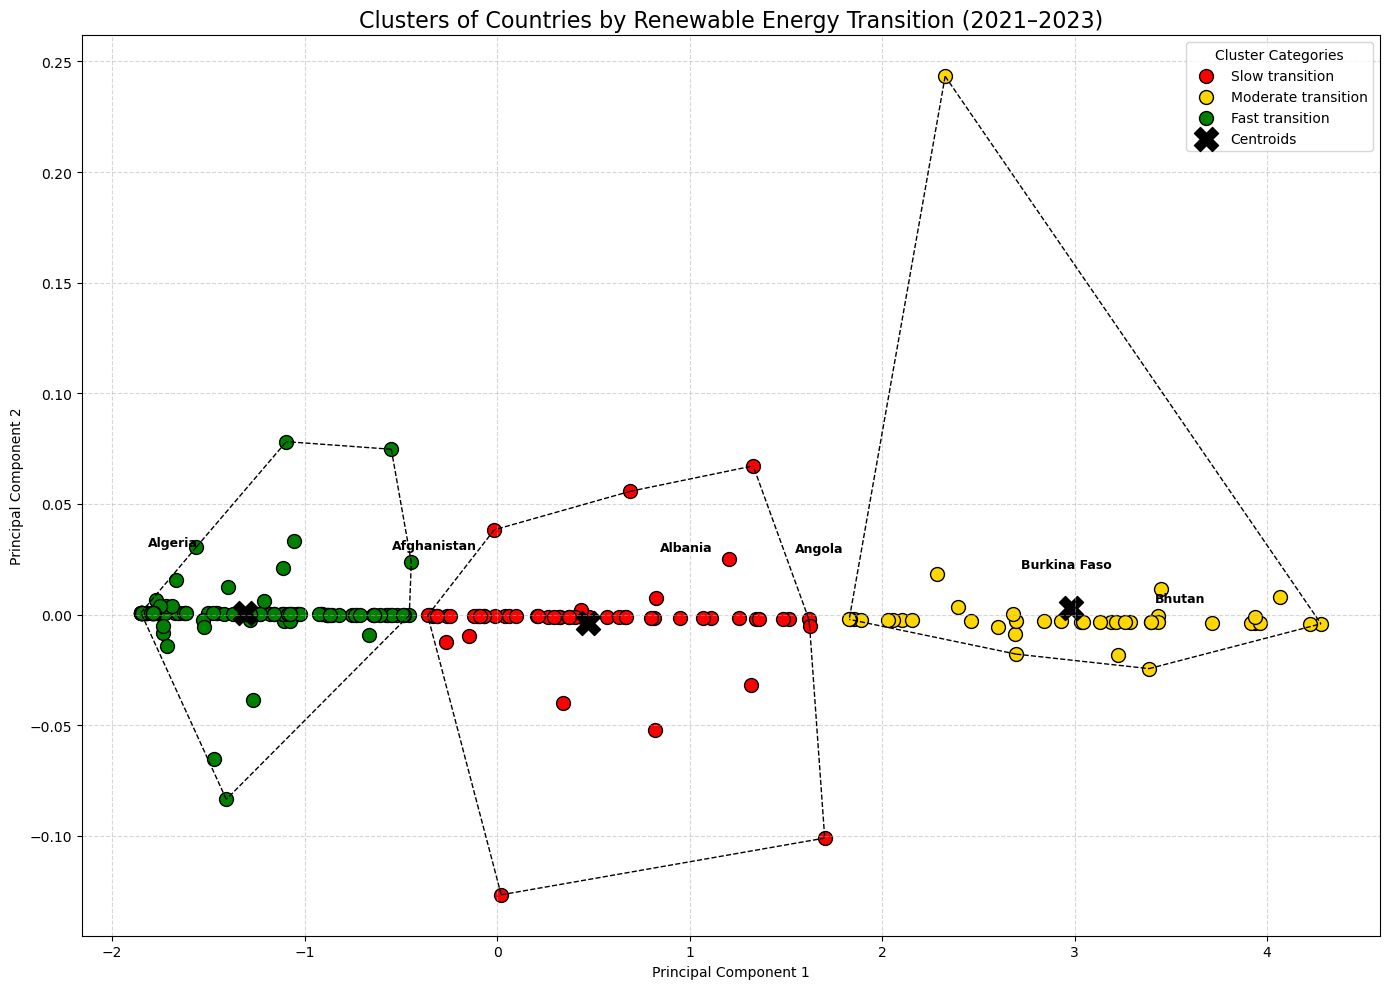

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import numpy as np

# 1. Prepare dataset
pivot = df_transition.pivot_table(index='Country Name', columns=df_transition['Time'].dt.year, values='Renewable_energy_consumption')
pivot = pivot.dropna()

scaler = StandardScaler()
scaled = scaler.fit_transform(pivot)

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled)
pivot['Cluster'] = clusters

# 2. Map cluster numbers to labels
cluster_labels = {
    0: "Moderate transition",
    1: "Fast transition",
    2: "Slow transition"
}
pivot['Cluster_Label'] = pivot['Cluster'].map(cluster_labels)

# 3. Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)

# 4. Create color palette manually
color_map = {
    "Slow transition": "red",
    "Moderate transition": "gold",
    "Fast transition": "green"
}

# 5. Plotting
plt.figure(figsize=(14,10))

# Plot each cluster separately to control colors
for cluster_name in color_map.keys():
    cluster_indices = pivot[pivot['Cluster_Label'] == cluster_name].index
    idx = [pivot.index.get_loc(country) for country in cluster_indices]
    plt.scatter(reduced[idx,0], reduced[idx,1], 
                color=color_map[cluster_name], 
                label=cluster_name, 
                s=100, edgecolor='black')

# Label only 3 countries from each cluster
for cluster_num in np.unique(clusters):
    cluster_idx = np.where(clusters == cluster_num)[0]
    selected_idx = cluster_idx[:2]###########################################################3
    for i in selected_idx:
        plt.text(reduced[i,0]+0.03, reduced[i,1]+0.03, pivot.index[i], fontsize=9, fontweight='bold')

# Cluster centroids
centroids_reduced = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_reduced[:,0], centroids_reduced[:,1], marker='X', s=300, c='black', label='Centroids')

# Draw convex hulls
for cluster_num in np.unique(clusters):
    points = reduced[clusters == cluster_num]
    if len(points) >= 3:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color='black', linestyle='--', linewidth=1)

plt.title('Clusters of Countries by Renewable Energy Transition (2021–2023)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Categories', loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Transition Over Time Captured via Clusters
Instead of showing raw time plots for every country individually (which would be very messy), grouped countries based on their renewable energy growth patterns from 2021 to 2023.
> Countries that had similar increases or stagnations in renewable energy share are clustered together
- Slow Adopters:	Countries with minimal growth or declining renewable share
- Moderate Adopters	:Countries with moderate but steady renewable transition
- Fast Adopters	: Countries showing strong and consistent renewable growth
Thus, you are summarizing 3 years of transition behavior through clustering.

> Emission Patterns Inferred Through Clusters
Typically, countries in the 
- Fast Adopter cluster (green) are expected to show lower or improving CO₂ emission trends because they are shifting toward renewables.
- Slow Adopters (red) likely have higher emissions or slower emission reduction because they rely more on fossil fuels.
- Moderate Adopters (yellow) are in between: showing progress, but slower compared to leaders.

> Major Economies or Specific Country Observations (Optional)
You can pick major economies (like China, USA, Germany, India, etc.)
and explain their cluster assignment:
Country	Cluster	Interpretation
- Germany	-Fast Adopter:	Strong renewable energy shift
- India	-Slow Adopter	Moderate progress, needs acceleration
- China	-Moderate Adopter	Large economy, but transition still slow relative to emissions burden
This gives individual country transition commentary based on cluster.

Let us link the clusters to emission data separately (which you already calculated with CO₂ trends earlier),
so we can can say:
> "Countries that transitioned faster toward renewable energy tended to have better (lower) CO₂ emission patterns than countries that adopted slowly."

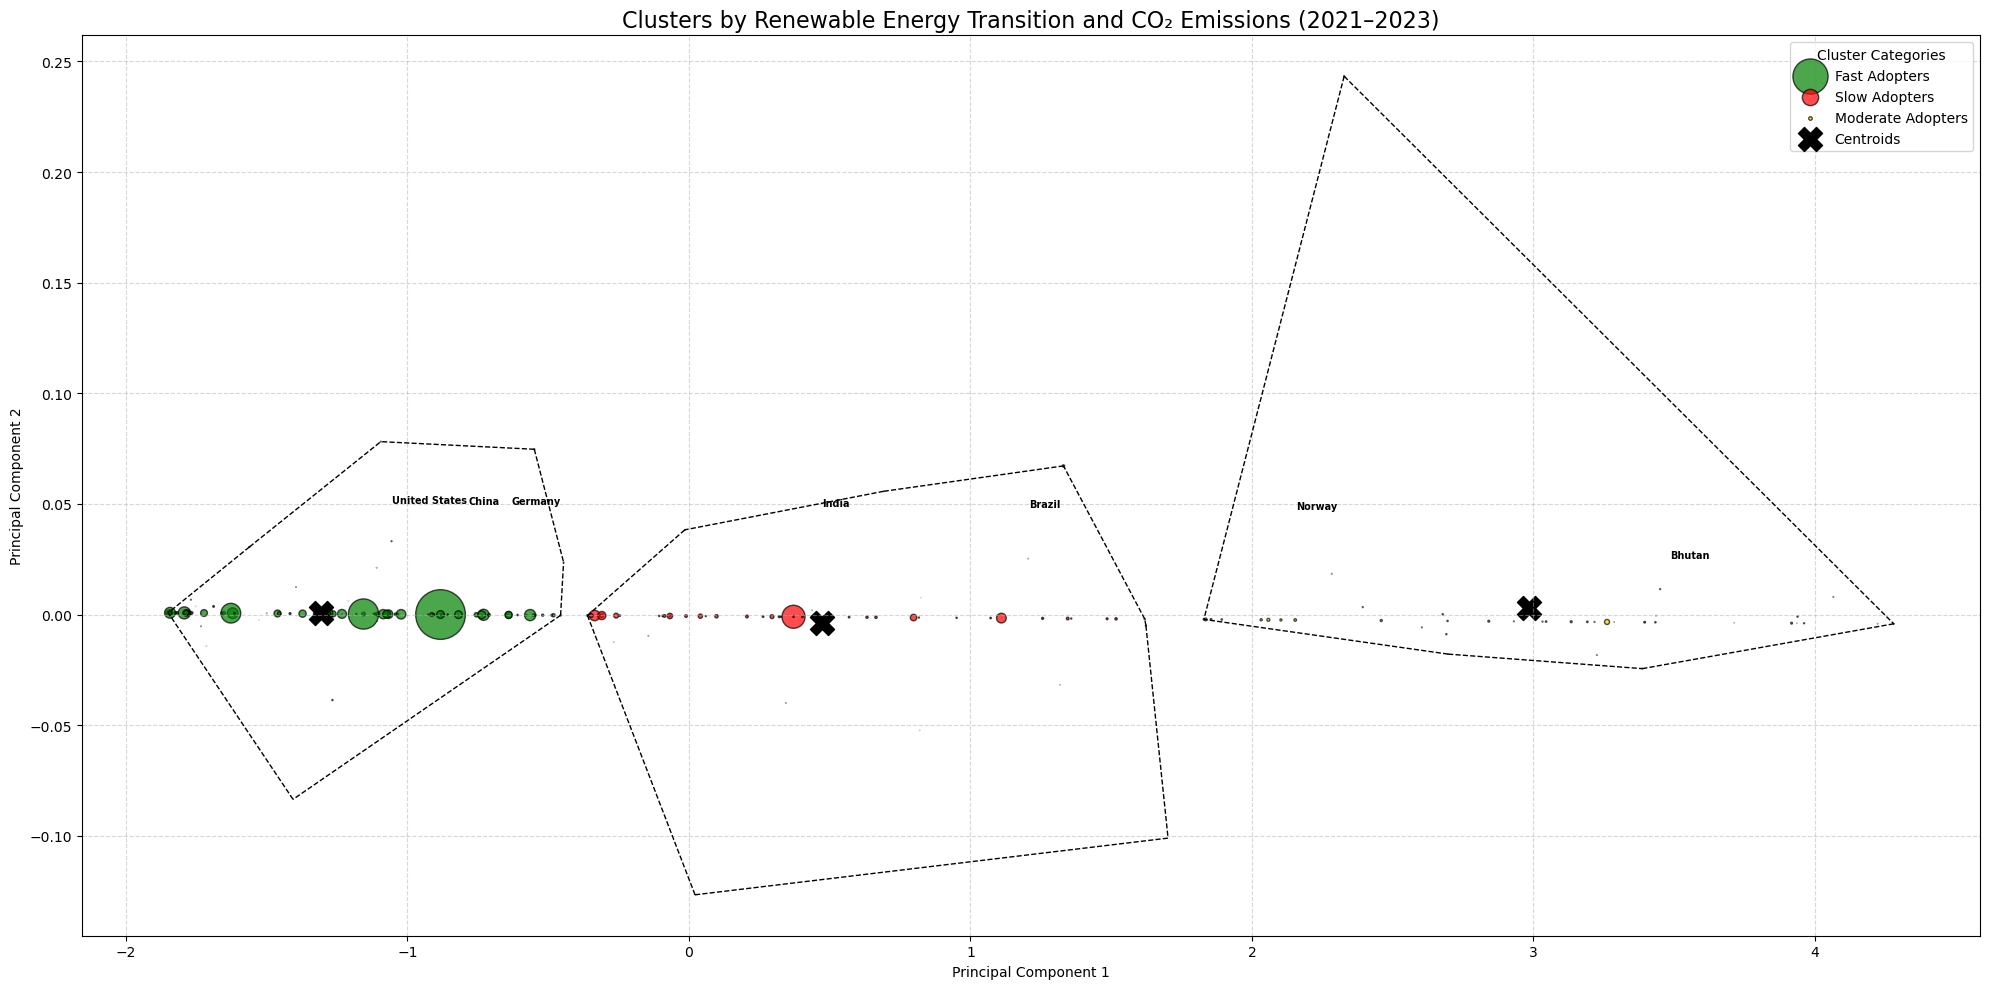

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull


# STEP 1: Filter years 2021–2023
df_transition = df_timeAnalysis.copy()
df_transition['Time'] = pd.to_datetime(df_transition['Time'], errors='coerce')
df_transition = df_transition[df_transition['Time'].dt.year.isin([2021, 2022, 2023])]

# STEP 2: Pivot for clustering on renewable energy transition
pivot = df_transition.pivot_table(index='Country Name',
                                  columns=df_transition['Time'].dt.year,
                                  values='Renewable_energy_consumption')

pivot = pivot.dropna()

# STEP 3: Scale the renewable transition data
scaler = StandardScaler()
scaled = scaler.fit_transform(pivot)

# STEP 4: KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled)
pivot['Cluster'] = clusters

# Map cluster numbers to meaningful labels
cluster_labels = {
    0: "Moderate Adopters",
    1: "Fast Adopters",
    2: "Slow Adopters"
}
pivot['Cluster_Label'] = pivot['Cluster'].map(cluster_labels)

# STEP 5: Average CO₂ emission (2021–2023)
co2_pivot = df_transition[df_transition['Country Name'].isin(pivot.index)].groupby('Country Name')['CO2_total_emissions'].mean()
pivot['CO2_mean'] = pivot.index.map(co2_pivot)

# STEP 6: PCA for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)

# STEP 7: Plotting
color_map = {
    "Slow Adopters": "red",
    "Moderate Adopters": "gold",
    "Fast Adopters": "green"
}
plt.figure(figsize=(20,10))

# Bubble size scaling
bubble_size = pivot['CO2_mean'].fillna(0).values / 10

# Plot clusters
for label in pivot['Cluster_Label'].unique():
    cluster_data = pivot[pivot['Cluster_Label'] == label]
    idx = [pivot.index.get_loc(country) for country in cluster_data.index]
    plt.scatter(reduced[idx, 0], reduced[idx, 1],
                s=bubble_size[idx],
                color=color_map[label],
                label=label,
                alpha=0.7,
                edgecolor='black')

# Add cluster centroids
centroids_2D = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1],
            marker='X', s=300, c='black', label='Centroids')

# Draw convex hulls
for cluster in pivot['Cluster'].unique():
    points = reduced[clusters == cluster]
    if len(points) >= 3:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],
                     color='black', linestyle='--', linewidth=1)

# STEP 8: Label important countries cleanly
key_countries = ['United States', 'China', 'India', 'Germany', 'Brazil', 'Russia', 'Bhutan', 'Norway']
#offset=0.07
texts = []
for i, country in enumerate(pivot.index):
    if country in key_countries:
        texts.append(
            plt.text(reduced[i, 0]+0.1, reduced[i, 1]+0.05, country,
                 fontsize=7, fontweight='bold')
        )

# Adjust text to avoid overlap
#adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

# Final touches
plt.title('Clusters by Renewable Energy Transition and CO₂ Emissions (2021–2023)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Categories', loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


> Category:	Observation
- Fast Adopters (Green)	:Transitioning faster toward renewable energy but still have large CO₂ emissions because many are big economies (e.g., China, US).
- Moderate Adopters (Gold)	:Moderate renewable adoption and moderate emissions.
- Slow Adopters (Red)	:Transitioning slowly but often smaller countries with relatively lower total emissions.

> Renewable Energy % (trend 2021–2023) was used for clustering.
- Average CO₂ Emissions by control the bubble size.
- Cluster color = Fast / Moderate / Slow adopters.
- Bigger bubbles = Higher average CO₂ emissions.
- Small bubbles = Lower average CO₂ emissions.
- Hulls drawn to group similar countries.
